# Keras MobileNet Benchmark

In a previous benchmark we used a simple three layer ConvNet. This time we use a deeper MobileNet architecture on greyscale strokes. 

This kernel has three main components:

* MobileNet
* Fast and memory efficient Image Generator with temporal colored strokes
* Full training & submission with Kaggle Kernel

I did some paramer search but it should not be hard to improve the current score.

## Setup
Import the necessary libraries and a few helper functions.

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import NASNetLarge
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.utils.training_utils import multi_gpu_model
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from SENet.se_mobilenets import SEMobileNet
from SENet.se_resnext import SEResNextImageNet
start = dt.datetime.now()

Using TensorFlow backend.


In [2]:
# !git clone https://github.com/titu1994/keras-squeeze-excite-network.git

In [3]:
!nvidia-smi

Thu Nov 22 17:49:06 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    54W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   39C    P0    56W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
DP_DIR = ''
INPUT_DIR = 'data/'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1997)
tf.set_random_seed(seed=1997)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [5]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## MobileNet

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)

In [6]:
STEPS = 150
EPOCHS = 15
size = 224
batchsize = int(128*2)

In [7]:
#model = DenseNet121(input_shape=(size, size, 1), weights=None, classes=NCATS)
#model.compile(optimizer=Adam(lr=0.0025), loss='categorical_crossentropy',
#              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
#print(model.summary())

In [8]:
# !git clone https://github.com/titu1994/keras-squeeze-excite-network.git

In [9]:
G=8
if G <= 1:
    print("[INFO] training with 1 GPU...")
    base_model = SEMobileNet(input_shape=(size,size,3),
                alpha=1.4,
                depth_multiplier=1,
                dropout=1e-3,
                include_top=False,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000)
    for l in base_model.layers:
        l.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(340, activation='softmax')(x)
    model = Model(base_model.input, x)
        # otherwise, we are compiling using multiple GPUs
else:
    print("[INFO] training with {} GPUs...".format(G))

    # we'll store a copy of the model on *every* GPU and then combine
    # the results from the gradient updates on the CPU
    with tf.device("/cpu:0"):
        # initialize the model
#         modell = MobileNet(input_shape=(size, size, 3), weights=None, classes=NCATS)
#         base_model = NASNetLarge(input_shape=(size,size,3), include_top=False, weights='imagenet')
        base_model = SEResNextImageNet(input_shape=(size,size,3),
                      depth=[3, 4, 23, 3],
                      cardinality=32,
                      width=4,
                      weight_decay=5e-4,
                      include_top=False,
                      weights='imagenet',
                      input_tensor=None,
                      pooling=None,
classes=1000)
#         base_model = SEMobileNet(input_shape=(size,size,3),
#                 alpha=1.4,
#                 depth_multiplier=1,
#                 dropout=1e-3,
#                 include_top=False,
#                 weights='imagenet',
#                 input_tensor=None,
#                 pooling=None,
#                 classes=1000)
        for l in base_model.layers:
            l.trainable = True
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(340, activation='softmax')(x)
        my_model = Model(base_model.input, x)
    # make the model parallel
    model = multi_gpu_model(my_model, gpus=G)
model.compile(optimizer=Adam(lr=0.004), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

[INFO] training with 8 GPUs...


In [10]:
# model.summary()

## Training with Image Generator

In [11]:
"""
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img
"""
colors = [(255, 0, 0) , (255, 255, 0),  (128, 255, 0),  (0, 255, 0), (0, 255, 128), (0, 255, 255), 
          (0, 128, 255), (0, 0, 255), (128, 0, 255), (255, 0, 255)]
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = colors[min(t, len(colors)-1)]
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw, lineType=cv2.LINE_AA)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 3))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, :] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 3))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, :] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

'\ndef draw_cv2(raw_strokes, size=256, lw=6, time_color=True):\n    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)\n    for t, stroke in enumerate(raw_strokes):\n        for i in range(len(stroke[0]) - 1):\n            color = 255 - min(t, 10) * 13 if time_color else 255\n            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),\n                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)\n    if size != BASE_SIZE:\n        return cv2.resize(img, (size, size))\n    else:\n        return img\n'

In [12]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=20000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(20000, 224, 224, 3) (20000, 340)
Validation array memory 11.22 GB


In [13]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

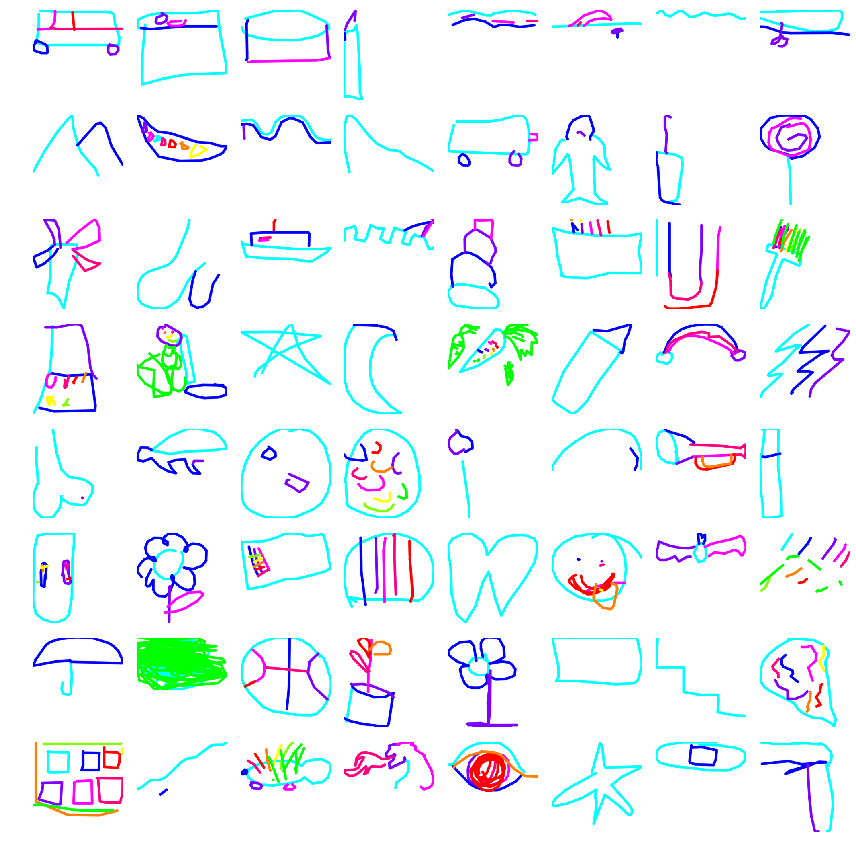

In [14]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, :] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,
                      min_delta=0.005, mode='max', cooldown=2, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen,steps_per_epoch=STEPS*G, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks,
    use_multiprocessing=True
)
hists.append(hist)

Epoch 1/15
1200/1200 [==============================] - 2881s 2s/step - loss: 8.5562 - categorical_crossentropy: 5.0504 - categorical_accuracy: 0.0423 - top_3_accuracy: 0.0998 - val_loss: 5.0371 - val_categorical_crossentropy: 4.5746 - val_categorical_accuracy: 0.0796 - val_top_3_accuracy: 0.1671
Epoch 2/15
1200/1200 [==============================] - 1756s 1s/step - loss: 4.7817 - categorical_crossentropy: 4.3626 - categorical_accuracy: 0.0963 - top_3_accuracy: 0.2072 - val_loss: 5.3786 - val_categorical_crossentropy: 4.9674 - val_categorical_accuracy: 0.0532 - val_top_3_accuracy: 0.1222
Epoch 3/15
  59/1200 [>.............................] - ETA: 26:52 - loss: 4.5763 - categorical_crossentropy: 4.1885 - categorical_accuracy: 0.1159 - top_3_accuracy: 0.2414

In [ ]:
!nvidia-smi

In [14]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,
                      min_delta=0.005, mode='max', cooldown=2, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen,steps_per_epoch=STEPS*G, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks,
    use_multiprocessing=True
)
hists.append(hist)

Epoch 1/15
1200/1200 [==============================] - 2032s 2s/step - loss: 2.5730 - categorical_crossentropy: 2.5730 - categorical_accuracy: 0.4192 - top_3_accuracy: 0.6073 - val_loss: 3.7692 - val_categorical_crossentropy: 3.7692 - val_categorical_accuracy: 0.1977 - val_top_3_accuracy: 0.3621
Epoch 2/15
1200/1200 [==============================] - 2005s 2s/step - loss: 1.5343 - categorical_crossentropy: 1.5343 - categorical_accuracy: 0.6288 - top_3_accuracy: 0.8114 - val_loss: 1.3681 - val_categorical_crossentropy: 1.3681 - val_categorical_accuracy: 0.6649 - val_top_3_accuracy: 0.8368
Epoch 3/15
1200/1200 [==============================] - 2038s 2s/step - loss: 1.3438 - categorical_crossentropy: 1.3438 - categorical_accuracy: 0.6734 - top_3_accuracy: 0.8428 - val_loss: 1.2728 - val_categorical_crossentropy: 1.2728 - val_categorical_accuracy: 0.6890 - val_top_3_accuracy: 0.8536
Epoch 4/15
1200/1200 [==============================] - 2095s 2s/step - loss: 1.2479 - categorical_crossen

In [14]:
savename="SE-MobileNet-Imagenet-128-first"

In [16]:
my_model.save(savename+".model")
my_model.save(savename+".h5")

In [18]:
import SENet
model = keras.models.load_model(savename+".h5", custom_objects={
                       'relu6': SENet.se_mobilenets.relu6,
                       'DepthwiseConv2D': SENet.se_mobilenets.DepthwiseConv2D})

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


AttributeError: 'Node' object has no attribute 'output_masks'

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,
                      min_delta=0.005, mode='max', cooldown=2, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen,steps_per_epoch=STEPS*G, epochs=EPOCHS-10, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks,
    use_multiprocessing=True
)
hists.append(hist)

Epoch 1/5
1200/1200 [==============================] - 2064s 2s/step - loss: 0.8723 - categorical_crossentropy: 0.8723 - categorical_accuracy: 0.7823 - top_3_accuracy: 0.9113 - val_loss: 0.8206 - val_categorical_crossentropy: 0.8206 - val_categorical_accuracy: 0.7913 - val_top_3_accuracy: 0.9145
Epoch 2/5
1200/1200 [==============================] - 2050s 2s/step - loss: 0.8645 - categorical_crossentropy: 0.8645 - categorical_accuracy: 0.7839 - top_3_accuracy: 0.9120 - val_loss: 0.8171 - val_categorical_crossentropy: 0.8171 - val_categorical_accuracy: 0.7900 - val_top_3_accuracy: 0.9153
Epoch 3/5
 890/1200 [=====================>........] - ETA: 8:45 - loss: 0.8576 - categorical_crossentropy: 0.8576 - categorical_accuracy: 0.7852 - top_3_accuracy: 0.9133

In [ ]:
#savename="mobilenet_with_imagenet"
savename="SE-MobileNet-Imagenet-128-second"
my_model.save(savename+".model")
# model.save(savename+".h5")

In [16]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, mode='max', cooldown=3, verbose=1,min_lr=0.00001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5)
callbacks = [reduceLROnPlat, earlystop]
hists = []
hist = model.fit_generator(
    train_datagen,steps_per_epoch=STEPS*G, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks,
    use_multiprocessing=True
)
hists.append(hist)

Epoch 1/15
1000/1000 [==============================] - 505s 505ms/step - loss: 0.9977 - categorical_crossentropy: 0.9977 - categorical_accuracy: 0.7502 - top_3_accuracy: 0.8944 - val_loss: 0.9361 - val_categorical_crossentropy: 0.9361 - val_categorical_accuracy: 0.7596 - val_top_3_accuracy: 0.8991
Epoch 2/15
1000/1000 [==============================] - 496s 496ms/step - loss: 0.9872 - categorical_crossentropy: 0.9872 - categorical_accuracy: 0.7548 - top_3_accuracy: 0.8958 - val_loss: 0.9344 - val_categorical_crossentropy: 0.9344 - val_categorical_accuracy: 0.7620 - val_top_3_accuracy: 0.8977
Epoch 3/15
1000/1000 [==============================] - 494s 494ms/step - loss: 0.9825 - categorical_crossentropy: 0.9825 - categorical_accuracy: 0.7544 - top_3_accuracy: 0.8970 - val_loss: 0.9136 - val_categorical_crossentropy: 0.9136 - val_categorical_accuracy: 0.7656 - val_top_3_accuracy: 0.9041
Epoch 4/15
1000/1000 [==============================] - 494s 494ms/step - loss: 0.9672 - categorical

In [11]:
!nvidia-smi

Tue Nov 20 17:07:40 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    45W / 300W |  15660MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   37C    P0    56W / 300W |  15660MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [19]:
savename="testwithrgb"
my_model.save(savename+".model")
my_model.save(savename+".h5")

In [6]:
from keras.models import load_model
my_model=load_model("testwithrgb.model")

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [15]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,min_lr=0.00001,
                      min_delta=0.0001, mode='max', cooldown=3, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS-10, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/5
300/300 [==============================] - 143s 476ms/step - loss: 0.8099 - categorical_crossentropy: 0.8099 - categorical_accuracy: 0.7915 - top_3_accuracy: 0.9201 - val_loss: 0.7978 - val_categorical_crossentropy: 0.7978 - val_categorical_accuracy: 0.7943 - val_top_3_accuracy: 0.9212
Epoch 2/5
300/300 [==============================] - 140s 466ms/step - loss: 0.8077 - categorical_crossentropy: 0.8077 - categorical_accuracy: 0.7914 - top_3_accuracy: 0.9197 - val_loss: 0.7967 - val_categorical_crossentropy: 0.7967 - val_categorical_accuracy: 0.7929 - val_top_3_accuracy: 0.9212
Epoch 3/5
300/300 [==============================] - 141s 470ms/step - loss: 0.8030 - categorical_crossentropy: 0.8030 - categorical_accuracy: 0.7916 - top_3_accuracy: 0.9212 - val_loss: 0.7946 - val_categorical_crossentropy: 0.7946 - val_categorical_accuracy: 0.7948 - val_top_3_accuracy: 0.9221
Epoch 4/5
300/300 [==============================] - 140s 466ms/step - loss: 0.7994 - categorical_crossentrop

In [9]:
!nvidia-smi

Wed Nov 21 10:23:12 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    45W / 300W |  15350MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   37C    P0    56W / 300W |  15350MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,
                      min_lr=0.00001, mode='max', cooldown=3, verbose=1)
]
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS*G, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/15
1200/1200 [==============================] - 501s 418ms/step - loss: 0.7702 - categorical_crossentropy: 0.7702 - categorical_accuracy: 0.8015 - top_3_accuracy: 0.9244 - val_loss: 0.7611 - val_categorical_crossentropy: 0.7611 - val_categorical_accuracy: 0.8020 - val_top_3_accuracy: 0.9253
Epoch 2/15
1200/1200 [==============================] - 500s 417ms/step - loss: 0.7600 - categorical_crossentropy: 0.7600 - categorical_accuracy: 0.8029 - top_3_accuracy: 0.9260 - val_loss: 0.7564 - val_categorical_crossentropy: 0.7564 - val_categorical_accuracy: 0.8032 - val_top_3_accuracy: 0.9265
Epoch 3/15
1200/1200 [==============================] - 502s 418ms/step - loss: 0.7537 - categorical_crossentropy: 0.7537 - categorical_accuracy: 0.8044 - top_3_accuracy: 0.9268 - val_loss: 0.7537 - val_categorical_crossentropy: 0.7537 - val_categorical_accuracy: 0.8041 - val_top_3_accuracy: 0.9265
Epoch 4/15
1200/1200 [==============================] - 500s 417ms/step - loss: 0.7479 - categorical

In [ ]:
savename="densenet121_two"
modell.save(savename+".model")
modell.save(savename+".h5")


In [ ]:

hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

In [16]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

ValueError: No objects to concatenate

In [19]:
valid_predictions = my_model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

10000/10000 [==============================] - 5s 510us/step
Map3: 0.840


## Create Submission

In [7]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, 128)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


MemoryError: 

In [ ]:
test_predictions = my_model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

In [ ]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('gs_mn_big_submission_densenet{}.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape

In [ ]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

In [ ]:
savename="first_try_big"
model.save(savename+".model")
model.save(savename+".h5")
